<a href="https://colab.research.google.com/github/vadhri/distibuted-optimization/blob/main/MethodOfMultipliers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

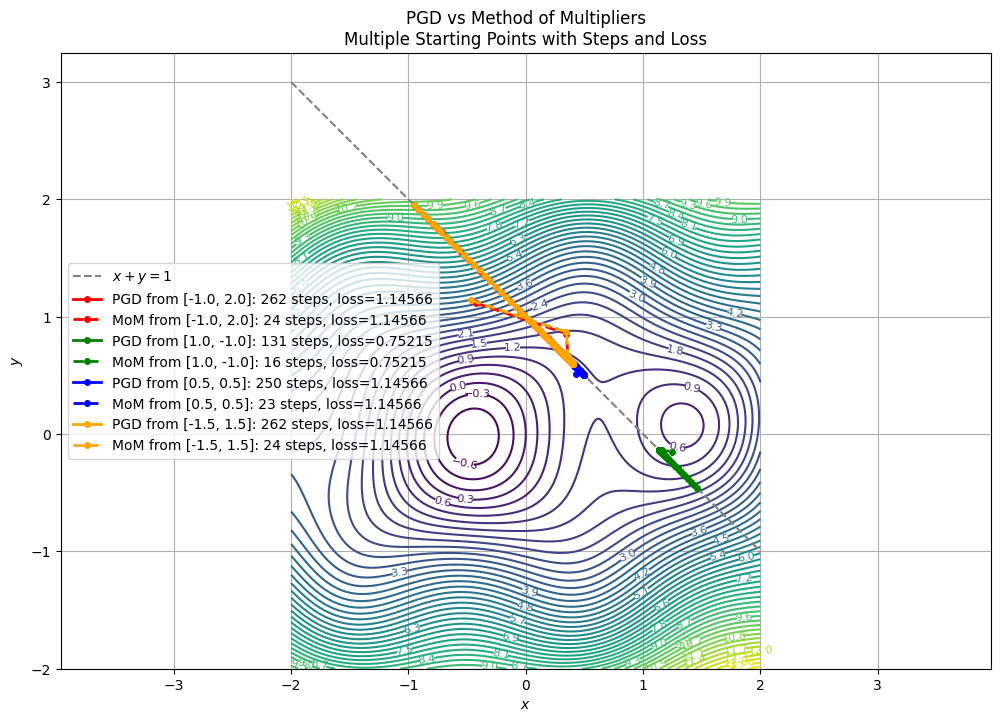

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Complex function
def f(xy):
    x, y = xy
    return 0.5 * x**2 + 2 * y**2 + np.sin(3*x) * np.cos(2*y) + 0.2 * (x - y)**2

def grad_f(xy):
    x, y = xy
    df_dx = x + 3 * np.cos(3*x) * np.cos(2*y) + 0.4 * (x - y)
    df_dy = 4 * y - 2 * np.sin(3*x) * np.sin(2*y) - 0.4 * (x - y)
    return np.array([df_dx, df_dy])

def project(xy):
    total = xy[0] + xy[1]
    correction = (total - 1.0) / 2
    return xy - correction * np.array([1.0, 1.0])

def c(xy):
    return xy[0] + xy[1] - 1

def grad_c():
    return np.array([1.0, 1.0])

# PGD from given starting point
def projected_gradient_descent(xy_start, alpha=0.01, max_iters=2000, tol=1e-5):
    xy = np.array(xy_start)
    xy_path = []

    for _ in range(max_iters):
        xy -= alpha * grad_f(xy)
        xy = project(xy)
        xy_path.append(xy.copy())

        if len(xy_path) >= 10:
            std_dev = np.std(np.array(xy_path[-10:]), axis=0).max()
            if std_dev < tol:
                break

    return np.array(xy_path)

# MoM from given starting point
def method_of_multipliers(xy_start, rho=10.0, alpha=0.01, max_iters=1000, tol=1e-5):
    xy = np.array(xy_start)
    lam = 0.0
    xy_path = []

    for _ in range(max_iters):
        for _ in range(20):
            grad = grad_f(xy) + (lam + rho * c(xy)) * grad_c()
            xy -= alpha * grad

        xy_path.append(xy.copy())
        lam += rho * c(xy)

        if len(xy_path) >= 10:
            std_dev = np.std(np.array(xy_path[-10:]), axis=0).max()
            if std_dev < tol:
                break

    return np.array(xy_path)

# Starting points
starting_points = [
    [-1.0, 2.0],
    [1.0, -1.0],
    [0.5, 0.5],
    [-1.5, 1.5]
]

# Plot contours
x_grid = np.linspace(-2, 2, 200)
y_grid = np.linspace(-2, 2, 200)
X, Y = np.meshgrid(x_grid, y_grid)
Z = f([X, Y])

plt.figure(figsize=(12, 8))
contours = plt.contour(X, Y, Z, levels=50, cmap='viridis')
plt.clabel(contours, inline=True, fontsize=8)

# Plot constraint line
x_line = np.linspace(-2, 2, 200)
y_line = 1 - x_line
plt.plot(x_line, y_line, '--', color='gray', label='$x + y = 1$')

# Optimize from each starting point
colors = ['red', 'green', 'blue', 'orange']
for i, xy_start in enumerate(starting_points):
    # PGD
    path_pgd = projected_gradient_descent(xy_start)
    steps_pgd = len(path_pgd)
    loss_pgd = f(path_pgd[-1])
    plt.plot(path_pgd[:,0], path_pgd[:,1], '-o', color=colors[i], linewidth=2, markersize=4,
             label=f'PGD from {xy_start}: {steps_pgd} steps, loss={loss_pgd:.5f}')

    # MoM
    path_mom = method_of_multipliers(xy_start)
    steps_mom = len(path_mom)
    loss_mom = f(path_mom[-1])
    plt.plot(path_mom[:,0], path_mom[:,1], '--o', color=colors[i], linewidth=2, markersize=4,
             label=f'MoM from {xy_start}: {steps_mom} steps, loss={loss_mom:.5f}')

# Final plot
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('PGD vs Method of Multipliers\nMultiple Starting Points with Steps and Loss')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


Iter 1: (x, y) = (1.187268, -0.087233), f(x, y) = 0.643131, constraint = 1.00e-01, lambda = 1.000358
Iter 2: (x, y) = (1.140303, -0.125701), f(x, y) = 0.735269, constraint = 1.46e-02, lambda = 1.146375
Iter 3: (x, y) = (1.132974, -0.131305), f(x, y) = 0.750204, constraint = 1.67e-03, lambda = 1.163068
Iter 4: (x, y) = (1.132128, -0.131945), f(x, y) = 0.751934, constraint = 1.83e-04, lambda = 1.164893
Iter 5: (x, y) = (1.132035, -0.132015), f(x, y) = 0.752124, constraint = 1.99e-05, lambda = 1.165092
Converged at iteration 6 with constraint violation 2.16e-06


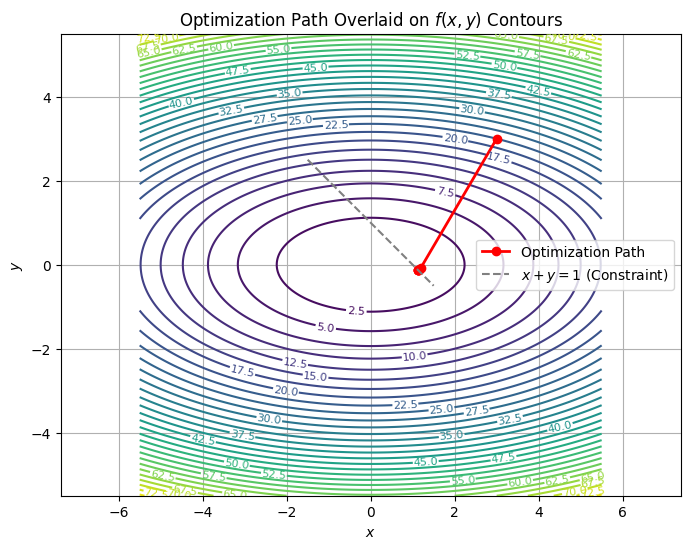

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Complex convex function
def f(xy):
    x, y = xy
    return 0.5 * x**2 + 2 * y**2 + np.sin(3*x) * np.cos(2*y) + 0.2 * (x - y)**2

# Gradient of complex function
def grad_f(xy):
    x, y = xy
    df_dx = x + 3 * np.cos(3*x) * np.cos(2*y) + 0.4 * (x - y)
    df_dy = 4 * y - 2 * np.sin(3*x) * np.sin(2*y) - 0.4 * (x - y)
    return np.array([df_dx, df_dy])

# Constraint: x + y = 1
def c(xy):
    x, y = xy
    return x + y - 1

# Gradient of constraint
def grad_c():
    return np.array([1.0, 1.0])

# Augmented Lagrangian gradient
def grad_L(xy, lam, rho):
    return grad_f(xy) + (lam + rho * c(xy)) * grad_c()

# Parameters
rho = 10.0
lam = 0.0
xy = np.array([3.0, 3.0])
alpha = 0.05
max_iters = 500
tol = 1e-5

xy_vals = [(3,3)]

# Optimization loop
for k in range(max_iters):
    for _ in range(50):
        grad = grad_L(xy, lam, rho)
        xy -= alpha * grad

    xy_vals.append(xy.copy())

    if abs(c(xy)) < tol:
        print(f"Converged at iteration {k+1} with constraint violation {c(xy):.2e}")
        break

    lam = lam + rho * c(xy)

    print(f"Iter {k+1}: (x, y) = ({xy[0]:.6f}, {xy[1]:.6f}), f(x, y) = {f(xy):.6f}, constraint = {c(xy):.2e}, lambda = {lam:.6f}")

xy_vals = np.array(xy_vals)

# Plot contour of f(x, y)
x_grid = np.linspace(-5.5, 5.5, 500)
y_grid = np.linspace(-5.5, 5.5, 500)
X, Y = np.meshgrid(x_grid, y_grid)
Z = 0.5 * X**2 + 2 * Y**2

plt.figure(figsize=(8, 6))
contours = plt.contour(X, Y, Z, levels=30, cmap='viridis')
plt.clabel(contours, inline=True, fontsize=8)

# Overlay optimization path
plt.plot(xy_vals[:, 0], xy_vals[:, 1], '-o', color='red', linewidth=2, label='Optimization Path')

# Plot constraint line: x + y = 1
x_line = np.linspace(-1.5, 1.5, 100)
y_line = 1 - x_line
plt.plot(x_line, y_line, linestyle='--', color='gray', label='$x + y = 1$ (Constraint)')

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Optimization Path Overlaid on $f(x, y)$ Contours')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


Converged at iteration 159, std dev = 9.70e-06


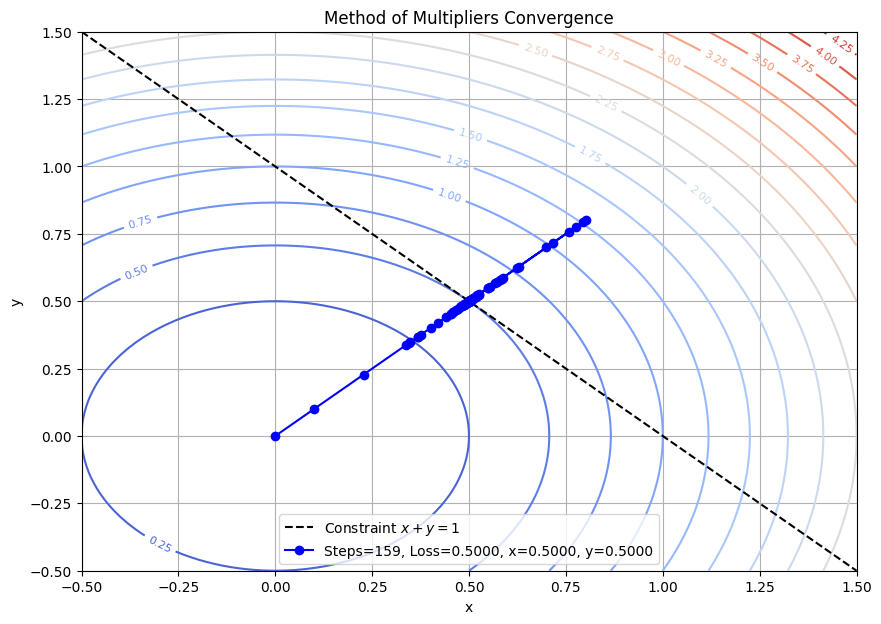

Minimize:  f(x, y) = x² + y²  subject to  x + y = 1


In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Objective and constraint
def f(x, y):
    return x**2 + y**2

def c(x, y):
    return x + y - 1

# Parameters
alpha = 0.01
rho = 10.0
lam = 0.0
clip_value = 20.0
tol = 1e-5  # Convergence tolerance (std deviation)

# Initialize
x, y = 0.0, 0.0
history = [(x, y, f(x, y))]

max_iters = 500

for k in range(max_iters):
    constraint_violation = c(x, y)

    grad_f_x = 2 * x
    grad_f_y = 2 * y

    multiplier_term = lam + rho * constraint_violation
    multiplier_term = np.clip(multiplier_term, -clip_value, clip_value)

    grad_x = grad_f_x + multiplier_term
    grad_y = grad_f_y + multiplier_term

    x -= alpha * grad_x
    y -= alpha * grad_y

    lam += rho * constraint_violation * 0.5

    history.append((x, y, f(x, y)))

    # Convergence check: std dev of last 10 steps
    if len(history) >= 10:
        recent = np.array(history[-10:])[:, :2]  # x and y
        if np.std(recent) < tol:
            print(f"Converged at iteration {k+1}, std dev = {np.std(recent):.2e}")
            break

# Extract final results
history = np.array(history)
final_loss = history[-1, 2]
total_steps = len(history) - 1
final_x = history[-1, 0]
final_y = history[-1, 1]

# Plotting
X, Y = np.meshgrid(np.linspace(-0.5, 1.5, 100),
                   np.linspace(-0.5, 1.5, 100))
Z = f(X, Y)

plt.figure(figsize=(10, 7))
cp = plt.contour(X, Y, Z, levels=20, cmap='coolwarm')
plt.clabel(cp, inline=True, fontsize=8)
plt.title('Method of Multipliers Convergence')

# Constraint line
x_line = np.linspace(-0.5, 1.5, 100)
y_line = 1 - x_line
plt.plot(x_line, y_line, 'k--', label='Constraint $x + y = 1$')

# Optimization path
plt.plot(history[:, 0], history[:, 1], 'bo-',
         label=f'Steps={total_steps}, Loss={final_loss:.4f}, x={final_x:.4f}, y={final_y:.4f}')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

# Print equation
print(r"Minimize:  f(x, y) = x² + y²  subject to  x + y = 1")


Converged at iteration 43
\begin{table}[h!]
\centering
\caption{Stabilized Method of Multipliers Iteration Data}
\begin{tabular}{c c c c c c}
\hline
Iter & $x_k$ & $y_k$ & $f(x_k,y_k)$ & $\lambda_k$ & $\rho_k$ \\
\hline
0 & 0.09901 & 0.09901 & 0.01961 & -0.50000 & 10.0 \\
10 & 0.50578 & 0.50578 & 0.51162 & -2.06426 & 113.9 \\
20 & 0.55017 & 0.55017 & 0.60538 & -120.81717 & 1946.2 \\
30 & 0.51688 & 0.51688 & 0.53432 & -254.72118 & 22168.4 \\
40 & 0.50073 & 0.50073 & 0.50147 & -336.46376 & 568151.3 \\
\hline
\end{tabular}
\end{table}


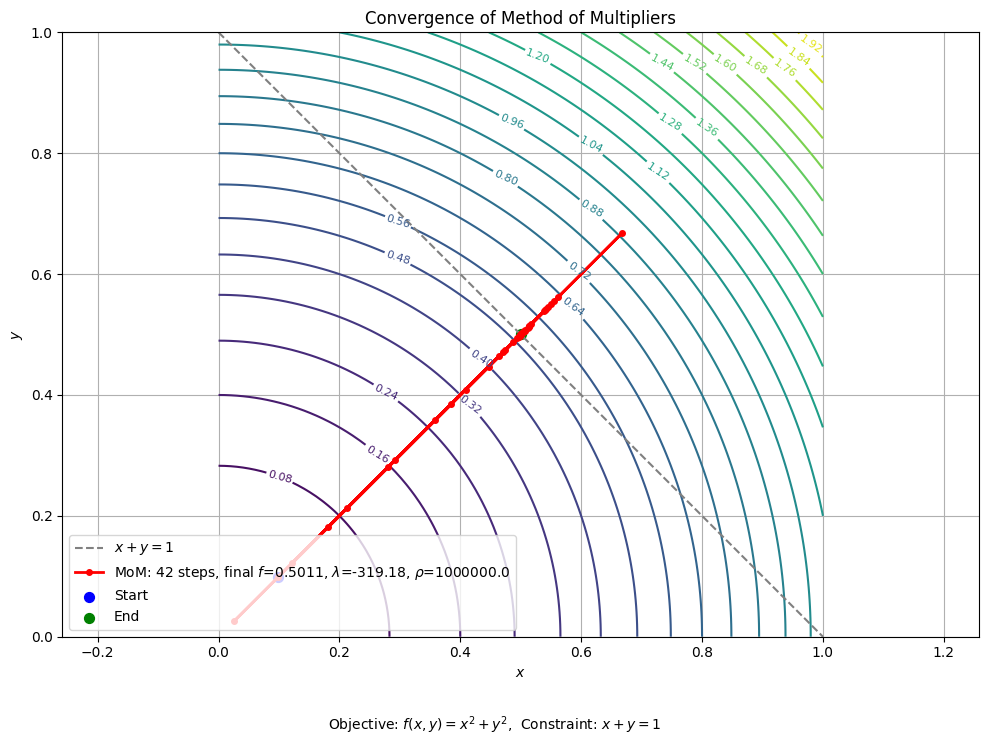

In [79]:
import numpy as np

# Objective and constraint
def f(x, y):
    return x**2 + y**2

def c(x, y):
    return x + y - 1

# Parameters
alpha0 = 0.01        # base learning rate
rho = 10.0
rho_max = 1e6
lam = 0.0
clip_value = 100.0   # clip multiplier term
clip_lambda = 10000  # clip lambda if needed
tol = 1e-3
eta = 0.05           # damping factor for multiplier update

# Initialize
x, y = 0.0, 0.0
history = []

max_iters = 1000
prev_constraint_violation = np.inf

for k in range(max_iters):
    constraint_violation = c(x, y)

    # Adaptive learning rate
    alpha = alpha0 / (1 + rho / 1000.0)

    # Gradient computation
    grad_f_x = 2 * x
    grad_f_y = 2 * y

    multiplier_term = lam + rho * constraint_violation
    multiplier_term = np.clip(multiplier_term, -clip_value, clip_value)

    grad_x = grad_f_x + multiplier_term
    grad_y = grad_f_y + multiplier_term

    x -= alpha * grad_x
    y -= alpha * grad_y

    # Damped multiplier update
    lam += rho * constraint_violation * eta
    lam = np.clip(lam, -clip_lambda, clip_lambda)

    obj = f(x, y)
    history.append((k, x, y, obj, lam, rho))

    # Adaptive rho update (if needed)
    if abs(constraint_violation) > 0.5 * abs(prev_constraint_violation):
        rho = min(rho * 1.5, rho_max)

    prev_constraint_violation = abs(constraint_violation)

    # Early stopping using std dev of last 10 iterates
    if len(history) >= 10:
        recent = np.array(history[-5:])[:, 1]
        if np.std(recent) < tol:
            print(f"Converged at iteration {k+1}")
            break

# Print LaTeX table
print("\\begin{table}[h!]")
print("\\centering")
print("\\caption{Stabilized Method of Multipliers Iteration Data}")
print("\\begin{tabular}{c c c c c c}")
print("\\hline")
print("Iter & $x_k$ & $y_k$ & $f(x_k,y_k)$ & $\\lambda_k$ & $\\rho_k$ \\\\")
print("\\hline")

for (iter_idx, x_val, y_val, obj_val, lam_val, rho_val) in history:
    if iter_idx % 10 == 0 or iter_idx == max_iters - 1:
        print(f"{iter_idx} & {x_val:.5f} & {y_val:.5f} & {obj_val:.5f} & {lam_val:.5f} & {rho_val:.1f} \\\\")

print("\\hline")
print("\\end{tabular}")
print("\\end{table}")

import numpy as np
import matplotlib.pyplot as plt

# Assuming `history` is already populated from your stabilized MoM run
# history = list of (iteration, x, y, f(x,y), lambda, rho)

# Extract arrays for plotting
history_arr = np.array(history)
x_vals = history_arr[:, 1]
y_vals = history_arr[:, 2]
f_vals = history_arr[:, 3]
lambda_vals = history_arr[:, 4]
rho_vals = history_arr[:, 5]
iterations = history_arr[:, 0]

# Objective contour plot
x_grid = np.linspace(0, 1, 100)
y_grid = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x_grid, y_grid)
Z = X**2 + Y**2

plt.figure(figsize=(10, 7))
contours = plt.contour(X, Y, Z, levels=30, cmap='viridis')
plt.clabel(contours, inline=True, fontsize=8)

# Plot constraint line x + y = 1
x_line = np.linspace(0, 1, 100)
y_line = 1 - x_line
plt.plot(x_line, y_line, '--', color='gray', label='$x + y = 1$')

# Plot optimization steps
plt.plot(x_vals, y_vals, '-o', color='red', markersize=4, linewidth=2,
         label=f'MoM: {int(iterations[-1])} steps, final $f$={f_vals[-1]:.4f}, '
               f'$\\lambda$={lambda_vals[-1]:.2f}, $\\rho$={rho_vals[-1]:.1f}')

# Annotate start and end
plt.scatter(x_vals[0], y_vals[0], color='blue', s=50, label='Start')
plt.scatter(x_vals[-1], y_vals[-1], color='green', s=50, label='End')

# Final plot details
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Convergence of Method of Multipliers')
plt.legend()
plt.grid(True)
plt.axis('equal')

# Display objective function formula below plot
plt.figtext(0.5, -0.05, r'Objective: $f(x, y) = x^2 + y^2$,  Constraint: $x + y = 1$',
            wrap=True, horizontalalignment='center', fontsize=10)

plt.tight_layout()
plt.show()
